<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Final-Project-Check-in" data-toc-modified-id="Final-Project-Check-in-1">Final Project Check-in</a></span></li><li><span><a href="#Group-Name" data-toc-modified-id="Group-Name-2">Group Name</a></span></li><li><span><a href="#Student-Names" data-toc-modified-id="Student-Names-3">Student Names</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-4">Load Data</a></span></li><li><span><a href="#Fit-scikit-learn-model" data-toc-modified-id="Fit-scikit-learn-model-5">Fit scikit-learn model</a></span></li><li><span><a href="#Evaluation-Metric" data-toc-modified-id="Evaluation-Metric-6">Evaluation Metric</a></span></li></ul></div>

Final Project Check-in
------

Group Name
-----

### Durian Candy 

Student Names
----

1. Andrew Young
2. Charles Siu
3. Sean Tey
4. Sunny Kwong 

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn import impute
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from rfpimp import *

Load Data
-----

In [2]:
df = pd.read_csv("../data/data_cleaned.csv")
df_copy = df.copy()

# Replace Categorical Missing Value and Do label encoding
cat_col = ['Nationality', 'Club', 'Preferred_Foot', 'Off_Work_Rate', 
           'Def_Work_Rate', 'Real_Face', 'Position', 'Loaned_Out', 'League_Country', 'League_Country']
df[cat_col] = df[cat_col].fillna(value='NA')  # fill na for categorical features
le = preprocessing.LabelEncoder()
for c in cat_col:
    df[c] = le.fit_transform(df[c])

In [3]:
y = df['Value']

In [4]:
X = df.drop('Value',axis=1)

### Quick simple EDA

In [ ]:
plt_row = 2
plt_col = 2
plt.figure(figsize = (plt_col * 4, plt_row * 3))

for i, col in enumerate(['Value', 'Age', 'Preferred_Foot', 'RF']):
    plt.subplot(plt_row, plt_col, i + 1)
    plt.subplots_adjust(hspace = 0.5)
    x = df_copy[col].dropna(axis=0)
    plt.hist(x)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')

Fit scikit-learn model
----

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### Define linear regression as a base model
Includes stepwise selection variables from init_sunny.ipynb

In [8]:
vanilla_lr = linear_model.LinearRegression()
# Uses best variables chosen by stepwise linear regression code
lr_vars = ['Wage', 'Release_Clause', 'Overall', 'International_Reputation', 'Age', 
           'League_Revenue', 'League_Revenue_Per_Team', 'SlidingTackle', 'Potential',
           'FKAccuracy', 'Position', 'Loaned_Out', 'Reactions', 'Marking']

# Have to fit two pipelines since Linear Regression has variable selection as well. 
numerical_lr_col =  list(set(lr_vars) - set(cat_col))

median_impute = impute.SimpleImputer(strategy='median')

numerical_names = numerical_lr_col

col_transform = compose.ColumnTransformer([('numerics',median_impute,numerical_names)])

steps_list = [('col_t',col_transform),('regressor',vanilla_lr)]

lr_pipeline = Pipeline(steps=steps_list)

lr_pipeline.fit(X_train[lr_vars], y_train)

Pipeline(memory=None,
     steps=[('col_t', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerics', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0), ['League_Revenue_Per_Team', 'Potential', ...gressor', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

### Define other models to try: Random Forest and LASSO

In [15]:
RF = RandomForestRegressor(n_estimators=30, min_samples_leaf=1)
lasso = linear_model.Lasso(tol=0.05)

In [16]:
numerical_col =  list(set(df.columns) - set(cat_col))
numerical_col.remove('Value')

In [17]:
def make_pipeline(regressors=None):
    pipelines = []
    
    for regressor in regressors:
        "Create a single pipeline that processing the data and then fits the regressor." 
        median_impute = impute.SimpleImputer(strategy='median')

        numerical_names = numerical_col

        col_transform = compose.ColumnTransformer([('numerics',median_impute,numerical_names)])

        steps_list = [('col_t',col_transform),('regressor',regressor)]

        pipeline = Pipeline(steps=steps_list)
        pipelines.append(pipeline)
    
    return pipelines

In [20]:
pipelines = make_pipeline([RF, lasso])
for pipeline in pipelines:
    pipeline.fit(X_train,y_train)

Evaluation Metric
----

In [10]:
def smape(y_test, y_pred):
    return 100/len(y_test) * np.sum(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))

In [31]:
scores = cross_val_score(lr_pipeline, X, y, cv=5, n_jobs=-1, scoring=make_scorer(smape))
print(f'Model: {type(lr_pipeline.named_steps["regressor"])}')
print('sMAPE: ', np.mean(scores))

Model: <class 'sklearn.linear_model.base.LinearRegression'>
sMAPE:  72.00112942582749


In [33]:
for pipeline in pipelines:
    scores = cross_val_score(pipeline, X, y, cv=5, n_jobs=-1, scoring=make_scorer(smape))
    print(f'Model: {type(pipeline.named_steps["regressor"])}')
    print('sMAPE: ', np.mean(scores))
    print('\n-------\n')

Model: <class 'sklearn.ensemble.forest.RandomForestRegressor'>
sMAPE:  22.281311963836167

-------

Model: <class 'sklearn.linear_model.coordinate_descent.Lasso'>
sMAPE:  94.11510605856802

-------



### Outcome
Random Forest has the lowest sMAPE value, therefore pick Random Forest as our final model

Feature Importance
---

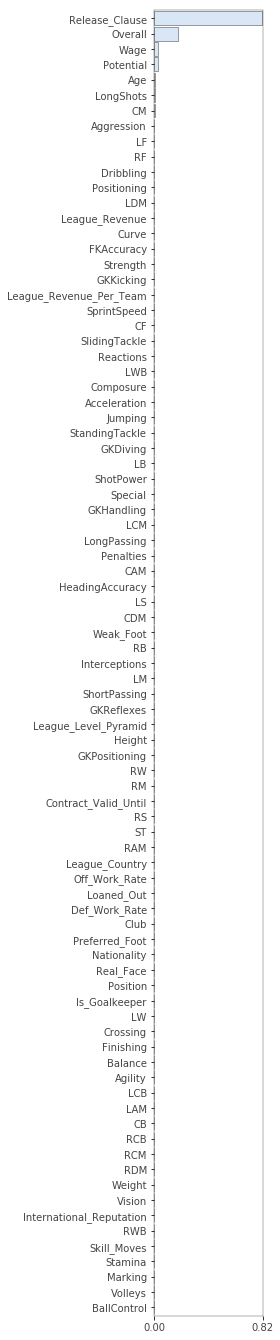

In [34]:
# original feature importance
pipeline = make_pipeline(RF)
pipeline[1].fit(X_train,y_train)
imp = importances(pipeline[1], X_test, y_test) # permutation
viz = plot_importances(imp)
viz.view()

In [35]:
X_train.head()

,Age,Nationality,Overall,Potential,Club,Wage,Special,Preferred_Foot,International_Reputation,Weak_Foot,...,GKReflexes,Release_Clause,League_Country,League_Level_Pyramid,League_Revenue,League_Revenue_Per_Team,Is_Goalkeeper,Loaned_Out,Off_Work_Rate,Def_Work_Rate
10946,23,138,64,72,274,0.002,1360,2,1.0,3.0,...,10.0,1.000,29,2.0,326.8,14.9,0,0,2,2
9025,36,138,66,66,460,0.002,1617,2,1.0,3.0,...,9.0,0.109,29,2.0,326.8,14.9,0,0,2,0
16090,20,46,57,68,634,0.006,1273,2,1.0,2.0,...,14.0,0.336,12,1.0,6562.0,328.1,0,0,2,2
13892,19,59,61,75,257,0.002,1451,2,1.0,2.0,...,15.0,1.200,15,1.0,3810.0,211.7,0,0,2,0
4341,27,9,71,72,500,0.011,1975,0,1.0,4.0,...,6.0,3.500,3,1.0,179.0,17.9,0,0,2,2


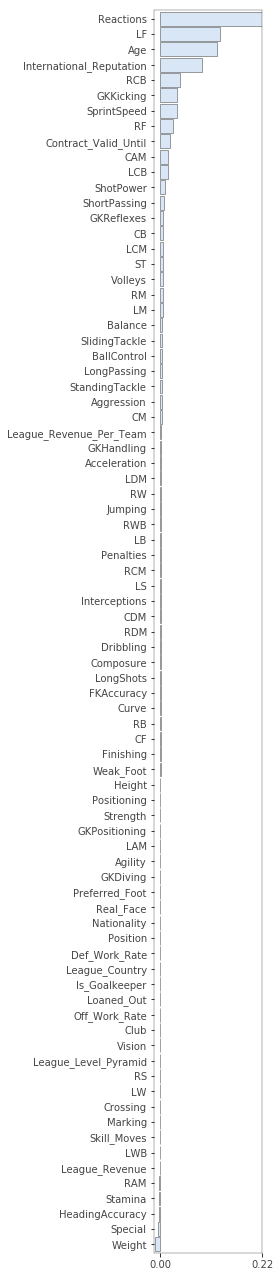

In [36]:
# # feature importance after dropping overall, release clause, and potential
df_drop = df.drop(['Overall', 'Release_Clause', 'Potential', 'Wage'], axis=1)
cat_col = ['Nationality', 'Club', 'Preferred_Foot', 'Off_Work_Rate', 
           'Def_Work_Rate', 'Real_Face', 'Position', 'Loaned_Out', 'League_Country', 'League_Country']

numerical_col = list(set(df_drop.columns) - set(cat_col))
numerical_col.remove('Value')
df_drop[cat_col] = df_drop[cat_col].fillna(value='NA')  # fill na for categorical features
le = preprocessing.LabelEncoder()
for c in cat_col:
    df_drop[c] = le.fit_transform(df_drop[c])
y = df_drop['Value']
X = df_drop.drop('Value',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
pipeline = make_pipeline(RF)
pipeline[1].fit(X_train,y_train)
#median_absolute_error(y_true=y_test,y_pred=y_pred)

imp = importances(pipeline[1], X_test, y_test) # permutation
viz = plot_importances(imp)
viz.view()

## Hyperparametes tuning (Random Forest)

In [47]:
random_grid = {"regressor__max_depth": list(range(1,30))+ [None],
                  "regressor__max_features": list(range(3, round(X_train.shape[1]/2))), # Max features 3 to half of total features 
                  "regressor__min_samples_split": list(range(2, 15))
                  }

pipeline = make_pipeline(RF)
search = RandomizedSearchCV(pipeline[1], param_distributions = random_grid, cv = 25)
search = search.fit(X, y)

KeyboardInterrupt: 

In [ ]:
# get the best hyperparameters
min_samples_split = search.best_params_['regressor__min_samples_split']
max_features = search.best_params_['regressor__max_features']
max_depth = search.best_params_['regressor__max_depth']
search.best_params_

In [ ]:
# retrain the model again
RF = RandomForestRegressor(min_samples_split=min_samples_split, max_features=max_features, max_depth=max_depth)
pipeline = make_pipeline([RF])
pipeline[0].fit(X_train,y_train)
scores = cross_val_score(pipeline[0], X, y, cv=5, n_jobs=-1, scoring=make_scorer(smape))
print(f'Model: {type(pipeline[0].named_steps["regressor"])}')
print('sMAPE: ', np.mean(scores))